In [0]:
from PIL import Image
import os
N = 100
L = 20
M = 2000
T = 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow

In [254]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def spam_extract(im, color):
  mask = np.zeros((N, N, 3))
  for i in range(N):
    for j in range(N-1):
      mask[i][j] += im[i][j] 
      mask[i][j] -= im[i][j+1]
  dim = T*2+1
  spam_feature = np.zeros((dim,dim))
  count_cond = np.zeros((dim,dim))
  for u in range(-T,T+1):
    for v in range(-T,T+1):
      for i in range(N):
        for j in range(N-1):
          if mask[i][j][color] == u:
            count_cond[u+T,v+T] += 1
            if mask[i][j+1][color] == v:
              spam_feature[u+T,v+T] += 1
  spam_feature /= count_cond
  spam_feature = spam_feature.reshape((1, dim*dim))[0]
  return spam_feature

In [0]:
def spam_extract_2nd(im, color):
  mask = np.zeros((N, N, 3))
  for i in range(N):
    for j in range(N-1):
      mask[i][j] += im[i][j] 
      mask[i][j] -= im[i][j+1]
  dim = T*2+1
  spam_feature = np.zeros((dim,dim,dim))
  count_cond = np.zeros((dim,dim,dim))
  for u in range(-T,T+1):
    for v in range(-T,T+1):
      for w in range(-T,T+1):
        for i in range(N):
          for j in range(N-2):
            if (mask[i][j][color] == v) and (mask[i][j+1][color] == w):
              count_cond[u+T,v+T,w+T] += 1
              if mask[i][j+2][color] == u:
                spam_feature[u+T,v+T,w+T] += 1
  spam_feature /= count_cond
  spam_feature = spam_feature.reshape((1, dim*dim*dim))[0]
  return spam_feature

In [0]:
import time
df = pd.DataFrame(columns=range( 2+3*(T*2+1)*(T*2+1)*(T*2+1)))
s=0
path = '/content/drive/My Drive/Colab Notebooks/new_set/3kpics/steg/'
for fn in os.listdir(path):
  im = imread(path+fn) 
  x = np.array([fn, 1])
  x = np.concatenate((x, spam_extract_2nd(im, 0)))
  x = np.concatenate((x, spam_extract_2nd(im, 1)))
  x = np.concatenate((x, spam_extract_2nd(im, 2)))
  df.loc[s] = x
  s+=1
path = '/content/drive/My Drive/Colab Notebooks/new_set/3kpics/clean/'
print('10% done')
print(time.ctime())
for fn in os.listdir(path):
  im = imread(path+fn)
  x = np.array([fn, 0])
  x = np.concatenate((x, spam_extract_2nd(im, 0)))
  x = np.concatenate((x, spam_extract_2nd(im, 1)))
  x = np.concatenate((x, spam_extract_2nd(im, 2)))
  df.loc[s] = x
  s+=1
df

In [0]:
df.to_csv('stegL=20.csv')

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/new_set/3kpics/stegdata2634.csv')

In [260]:
from sklearn.utils import shuffle
df = shuffle(df)
df = df.drop(columns=['Unnamed: 0'])
df = df.reset_index(drop = True)
#df = df.drop("res", axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,51.png,0,975,0.088889,0.113636,0.046512,0.024390,0.000000,0.000000,0.000000,0.106383,0.067797,0.036145,0.041237,0.020000,0.029412,0.000000,0.217391,0.100000,0.070866,0.023585,0.009804,0.047619,0.045455,0.047619,0.076923,0.025000,0.016129,0.017964,0.022222,0.048780,0.147059,0.093750,0.100000,0.022436,0.032609,0.036145,0.033898,0.090909,0.041667,...,0.012658,0.061538,0.147059,0.026316,0.105263,0.000000,0.025316,0.036036,0.030120,0.069444,0.035714,0.060606,0.000000,0.016949,0.039773,0.009434,0.021858,0.093750,0.081633,0.028571,0.020408,0.000000,0.049853,0.035000,0.111111,0.088889,0.000000,0.066667,0.020833,0.024096,0.068493,0.061224,0.128205,0.000000,0.000000,0.062500,0.052632,0.051724,0.090909,0.088235
1,1712.png,0,1044,0.058824,0.053571,0.040000,0.000000,0.034483,0.038462,0.030303,0.187500,0.094340,0.043478,0.032787,0.022727,0.080000,0.000000,0.026316,0.095238,0.031915,0.025641,0.042857,0.014493,0.029412,0.044444,0.101695,0.069767,0.050420,0.027027,0.034483,0.029412,0.117647,0.130435,0.064103,0.067308,0.056180,0.081967,0.040816,0.102564,0.115385,...,0.030303,0.066667,0.103448,0.067797,0.083333,0.057143,0.059701,0.046296,0.043956,0.055556,0.064516,0.106383,0.032787,0.034091,0.063830,0.008772,0.073684,0.053333,0.146341,0.000000,0.036364,0.054348,0.040984,0.022472,0.111111,0.086957,0.043478,0.071429,0.033898,0.051546,0.042254,0.108696,0.162162,0.050000,0.000000,0.040000,0.000000,0.023810,0.021277,0.000000
2,105.png,0,894,0.080000,0.121951,0.045455,0.031250,0.034483,0.000000,0.058824,0.097561,0.113636,0.152778,0.020833,0.026316,0.055556,0.052632,0.040000,0.082192,0.067797,0.039604,0.000000,0.023810,0.026316,0.192308,0.126984,0.098901,0.035461,0.029412,0.031250,0.062500,0.150000,0.117647,0.136364,0.023529,0.021277,0.000000,0.039216,0.062500,0.235294,...,0.061538,0.052632,0.037037,0.037037,0.173913,0.000000,0.063492,0.040323,0.055556,0.115789,0.125000,0.027778,0.060606,0.120690,0.024390,0.056180,0.062500,0.085366,0.052632,0.028571,0.061224,0.053763,0.025974,0.046875,0.046512,0.088889,0.000000,0.000000,0.000000,0.012821,0.030303,0.063492,0.108108,0.000000,0.000000,0.032258,0.029412,0.061224,0.064516,0.083333
3,1379.png,1,5037,0.047619,0.080000,0.153846,0.040268,0.086957,0.064516,0.000000,0.068966,0.166667,0.053763,0.067039,0.110092,0.035714,0.000000,0.014925,0.055276,0.073171,0.044674,0.041958,0.026846,0.034884,0.015038,0.071856,0.025090,0.054250,0.056561,0.012048,0.040816,0.059524,0.163462,0.009740,0.069544,0.020270,0.037500,0.025641,0.037037,0.185185,...,0.048387,0.054545,0.037736,0.062500,0.000000,0.037037,0.026178,0.039024,0.072978,0.014925,0.121212,0.034091,0.024793,0.006098,0.048117,0.056159,0.019784,0.095238,0.021739,0.023256,0.021739,0.040698,0.030132,0.063291,0.104294,0.035088,0.115385,0.000000,0.137931,0.074074,0.044944,0.113924,0.048780,0.052632,0.000000,0.083333,0.028777,0.131148,0.071429,0.200000
4,1468.png,1,4377,0.000000,0.028571,0.142857,0.025000,0.000000,0.040000,0.000000,0.035714,0.222222,0.000000,0.052632,0.024390,0.000000,0.038462,0.058824,0.037037,0.052632,0.021622,0.042735,0.046512,0.000000,0.071429,0.046512,0.011834,0.032086,0.012500,0.056338,0.030303,0.000000,0.023256,0.000000,0.066667,0.059524,0.010989,0.125000,0.300000,0.166667,...,0.145833,0.088889,0.075000,0.105263,0.000000,0.040000,0.119048,0.055556,0.123188,0.041096,0.133333,0.058824,0.104167,0.023256,0.108333,0.091954,0.038095,0.157143,0.045977,0.032258,0.035714,0.125000,0.041667,0.054348,0.073529,0.000000,0.047619,0.000000,0.061538,0.132353,0.000000,0.140000,0.047619,0.040000,0.000000,0.044118,0.042254,0.052632,0.112903,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
df.replace('nan', np.nan, inplace=True)

In [0]:
df.fillna(0, inplace=True)

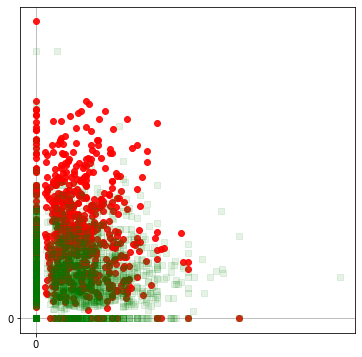

In [264]:
def graph(i,j):
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for k in range(len(df['1'])):
        if df['1'][k]!=1:
            x1.append(df[i][k])
            y1.append(df[j][k])
        else:
            x2.append(df[i][k])
            y2.append(df[j][k])
    plt.plot(x2, y2, "ro", alpha = 0.9)              #red - Steg
    plt.plot(x1, y1, "gs", alpha = 0.1)              #green - Legit
    plt.grid()

plt.figure(figsize=(6,6))
graph('4', '128')
plt.yticks(np.arange(0, 1, 1.0))
plt.xticks(np.arange(0, 1, 1.0))

plt.show()

In [241]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': range(500,1000,100), 'max_depth': range(1,12)}


clf = RandomForestClassifier()
X = df.iloc[:M,2:]
y = df['1'][:M].values
X.transpose()
clf_grid = GridSearchCV(clf, params, cv=5)
clf_grid.fit(X, y)
clf_grid.best_params_
best_tree = clf_grid.best_estimator_
best_tree

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

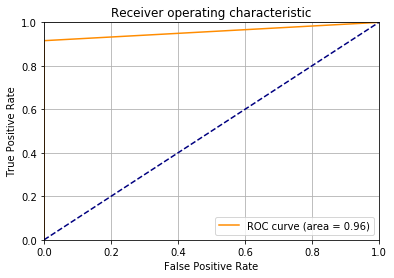

In [265]:
from sklearn.metrics import roc_curve, auc

X = df.iloc[:M,2:]
y = df['1'][:M].values
X.transpose()
P = df.iloc[M:,2:]
P = P.transpose()

best_tree = RandomForestClassifier(max_depth=10, n_estimators=1000)
best_tree.fit(X, y)  
#print(best_tree.feature_importances_)

dct = {}
df["res"] = df['1'].map(dct)
for i in range(M,len(df["res"])):
    p0 = best_tree.predict([P[i].tolist()])[0]
    df.loc[i, "res"] = p0
y = np.array(df['1'][M:])
x0 = np.array(df["res"][M:])
x0 = [int(item) for item in x0]
y = [int(item) for item in y]
y[1]=1
#print(x0,y)
fpr, tpr, thresholds = roc_curve(y,x0,pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
df = df.drop("res", axis=1)